In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
mycountry = ['VNM']
peers = ['CHN', 'LAO', 'THA', 'AGO', 'MMR', 'UZB', 'WSM']
mycountries = peers + mycountry

In [4]:
df1 = pd.read_csv('H0_5Y_1.csv')
df2 = pd.read_csv('H0_5Y_2.csv')
df = df1.append(df2)
df = df.drop('Unnamed: 0', axis=1)
allcountries = df['exporter'].unique()[1:]
df.head()

,year,exporter,commoditycode,export_value
0,1995,ABW,0101,17100.0
1,1995,ABW,0102,0.0
2,1995,ABW,0103,0.0
3,1995,ABW,0104,0.0
4,1995,ABW,0105,0.0


In [5]:
HS = pd.DataFrame(df.commoditycode.unique())
HS.columns = ['commoditycode']
HS.head()

,commoditycode
0,0101
1,0102
2,0103
3,0104
4,0105


In [6]:
#import HS to NAICS concordance
NAICS = pd.read_csv('HS_NAICS.csv')
NAICS = NAICS.drop('Unnamed: 0', axis=1)
NAICS.columns = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm']
NAICS.index = HS['commoditycode'][0:-2]
NAICS.head()

,a,b,c,d,e,f,g,h,i,j,k,l,m
commoditycode,,,,,,,,,,,,,
0101,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0104,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0105,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
test = pd.DataFrame(NAICS.stack())
test = test.loc[test[0] != '.']
test = test.loc[test[0] != np.nan]
test = test.loc[test[0] != 'NaN']
test = test.reset_index()
test = test.drop('level_1', axis=1)
test.head()

,commoditycode,0
0,0210,311920
1,0702,327212
2,0710,339913
3,0710,331491
4,0711,331491


In [8]:
test2 = test.merge(df, on='commoditycode', how='outer')
test2.columns = ['hs', 'naics', 'year', 'exporter', 'export_value']
test2 = test2.dropna()
test2.head()

,hs,naics,year,exporter,export_value
0,0210,311920,1995,ABW,0.0
1,0210,311920,1995,AFG,0.0
2,0210,311920,1995,AGO,0.0
3,0210,311920,1995,AIA,0.0
4,0210,311920,1995,ALB,0.0


In [9]:
test2['counter'] = 1
test2['naics_count'] = test2.groupby(['exporter', 'year', 'hs'])['counter'].transform(sum)
test2['export_1'] = test2.groupby(['exporter', 'year', 'naics', 'hs'])['export_value'].transform(sum)
test2['export_1'] = test2['export_1'] / test2['naics_count']
test2['export_2'] = test2.groupby(['exporter', 'year', 'naics'])['export_1'].transform(sum)
test2 = test2.drop_duplicates(['exporter', 'year', 'naics'])
test2 = test2.sort_values(['year', 'exporter', 'naics'])
test2.head()

,hs,naics,year,exporter,export_value,counter,naics_count,export_1,export_2
209324,2106,311920,1995,ABW,44074.0,1,8,5509.250,5509.250
1162554,6211,315234,1995,ABW,7643.0,1,8,955.375,955.375
886992,4819,322214,1995,ABW,0.0,1,9,0.000,0.000
708954,3926,326220,1995,ABW,2745.0,1,9,305.000,305.000
2268204,9403,327212,1995,ABW,0.0,1,8,0.000,0.000


In [10]:
naics_ex = test2.drop(['hs', 'export_value', 'counter', 'naics_count', 'export_1'], axis=1)
naics_ex = naics_ex.reset_index()
naics_ex = naics_ex.drop('index', axis=1)
naics_ex.columns = ['naics', 'year', 'exporter', 'export_value']
naics_ex['naics'] = naics_ex['naics'].astype(str)
naics_ex.head()

,naics,year,exporter,export_value
0,311920.0,1995,ABW,5509.250
1,315234.0,1995,ABW,955.375
2,322214.0,1995,ABW,0.000
3,326220.0,1995,ABW,305.000
4,327212.0,1995,ABW,0.000


In [11]:
IDlist = naics_ex['naics'].unique()

In [12]:
concord = pd.read_csv('NAICS_BEA.csv')
concord['long_naics'] = np.nan

for i in range(0, len(concord)):
        templen = len(str(concord['NAICS Code'][i]))
        for j in IDlist:
            this = j
            if this[0:templen] == str(concord['NAICS Code'][i]):
                concord.loc[i,'long_naics'] = this

concord = concord.drop(['Title', 'NAICS Code'],axis=1)
concord.columns = ['BEA', 'naics']
concord = concord.dropna()
concord.head()

,BEA,naics
0,1111A0,111110
1,1111A0,111120
3,1111B0,111140
4,1111B0,111150
5,1111B0,111160


In [13]:
BEA_ex = concord.merge(naics_ex, on='naics', how='outer')
BEA_ex = BEA_ex.dropna()
BEA_ex = BEA_ex.sort_values(['exporter', 'year', 'BEA'])
BEA_ex['export_agg'] = BEA_ex.groupby(['exporter', 'year', 'BEA'])['export_value'].transform(sum)
BEA_ex = BEA_ex.drop(['export_value', 'naics'], axis=1)
BEA_ex = BEA_ex.drop_duplicates(['exporter', 'year', 'BEA'])
BEA_ex['export_tot'] = BEA_ex.groupby(['exporter', 'year'])['export_agg'].transform(sum)
BEA_ex['export_share'] = BEA_ex['export_agg'] / BEA_ex['export_tot']
BEA_ex['log_export'] = np.log(BEA_ex['export_agg']+1)
BEA_ex = BEA_ex.drop(['export_agg', 'export_tot'], axis=1)

BEA_ex.head()

,BEA,year,exporter,export_share,log_export
0,1111A0,1995,ABW,0.003702,14.260593
2268,1111B0,1995,ABW,0.016417,15.750102
6804,111200,1995,ABW,0.000000,0.000000
7938,111300,1995,ABW,0.000000,0.000000
9072,111400,1995,ABW,0.000000,0.000000


## external finance dependence

In [14]:
isic_list = pd.read_csv('isic_list.csv')
isic_list.head()

,code
0,311
1,313
2,314
3,321
4,322


In [15]:
ISIC = pd.read_csv('HS_ISIC.csv')
ISIC = ISIC.drop('Unnamed: 0', axis=1)
ISIC.index = isic_list['code']
ISIC.head()

,1,2,3,4,5,6,7,8,9,10,...,536,537,538,539,540,541,542,543,544,545
code,,,,,,,,,,,,,,,,,,,,,
311,20110,20120,20130,20210,20220,20230,20311.0,20312.0,20319.0,20321.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
313,110710,110720,220110,220190,220210,220290,220300.0,220410.0,220421.0,220429.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,240210,240220,240290,240310,240391,240399,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
321,50300,120720,140210,140291,140299,140420,460110.0,460120.0,460191.0,460199.0,...,630710.0,630720.0,630790.0,630800.0,630900.0,631010.0,631090.0,701910.0,701920.0,880400.0
322,392620,401511,401519,401590,411000,420310,420321.0,420329.0,420330.0,420340.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [16]:
test = pd.DataFrame(ISIC.stack())
test[0] = test[0].astype(int)
test[0] = test[0].astype(str)
test = test.loc[test[0] != '.']
test = test.loc[test[0] != np.nan]
test = test.loc[test[0] != 'NaN']
test = test.reset_index()
test = test.drop('level_1', axis=1)
test.columns = ['isic', 'commoditycode']
test['commoditycode'] = test['commoditycode'].astype(str).str[0:4]
test = test.sort_values('commoditycode')
test.head()

,isic,commoditycode
106,311,1006
107,311,1006
108,311,1101
112,311,1102
109,311,1102


In [17]:
test2 = test.merge(df, on='commoditycode', how='inner')
test2.columns = ['isic', 'hs', 'year', 'exporter', 'export_value']
test2 = test2.dropna()
test2['counter'] = 1
test2['isic_count'] = test2.groupby(['exporter', 'year', 'hs'])['counter'].transform(sum)
test2['export_1'] = test2.groupby(['exporter', 'year', 'isic', 'hs'])['export_value'].transform(sum)
test2['export_1'] = test2['export_1'] / test2['isic_count']
test2['export_2'] = test2.groupby(['exporter', 'year', 'isic'])['export_1'].transform(sum)
test2 = test2.drop_duplicates(['exporter', 'year', 'isic'])
test2 = test2.sort_values(['year', 'exporter', 'isic'])
test2.head()

,isic,hs,year,exporter,export_value,counter,isic_count,export_1,export_2
0,311,1006,1995,ABW,13842423.0,1,2,13842423.0,28974091.25
30618,313,1107,1995,ABW,0.0,1,2,0.0,12891470.00
274428,314,2402,1995,ABW,0.0,1,3,0.0,0.00
34020,321,1207,1995,ABW,0.0,1,2,0.0,250412.00
1352862,322,3926,1995,ABW,2745.0,1,5,549.0,1052627.00


In [18]:
isic_ex = test2.drop(['hs', 'export_value', 'counter', 'isic_count', 'export_1'], axis=1)
isic_ex = isic_ex.reset_index()
isic_ex = isic_ex.drop('index', axis=1)
isic_ex.columns = ['isic', 'year', 'exporter', 'export_value']
isic_ex['isic'] = isic_ex['isic'].astype(str)
isic_ex.head()

,isic,year,exporter,export_value
0,311,1995,ABW,28974091.25
1,313,1995,ABW,12891470.00
2,314,1995,ABW,0.00
3,321,1995,ABW,250412.00
4,322,1995,ABW,1052627.00


In [19]:
efd = pd.read_csv('Other Factors/external dependency.csv')
efd['ISIC code'] = efd['ISIC code'].astype(int)
efd['ISIC code'] = efd['ISIC code'].astype(str)
efd.columns = ['isic', 'sector', 'ed 1980', 'ed', 'ed non-crisis', 'liq 1980', 'liq -99', 'durable', 'intangibility', 'tangibility', 'KtoL', 'RnDI']
efd = efd.drop(['sector', 'ed 1980', 'ed non-crisis', 'liq 1980', 'liq -99', 'durable', 'intangibility', 'tangibility', 'KtoL', 'RnDI'], axis=1)
efd.head()

,isic,ed
0,311,-0.15
1,313,0.03
2,314,-1.14
3,321,0.01
4,322,-0.21


In [20]:
ed_reg = isic_ex.merge(efd, on='isic', how='outer')
ed_reg['export_agg'] = ed_reg.groupby(['exporter', 'year', 'isic'])['export_value'].transform(sum)
ed_reg = ed_reg.drop(['export_value'], axis=1)
ed_reg = ed_reg.drop_duplicates(['exporter', 'year', 'isic'])
ed_reg['export_tot'] = ed_reg.groupby(['exporter', 'year'])['export_agg'].transform(sum)
ed_reg['export_share'] = ed_reg['export_agg'] / ed_reg['export_tot']
ed_reg['log_export'] = np.log(ed_reg['export_agg']+1)
ed_reg = ed_reg.drop(['export_agg', 'export_tot'], axis=1)
ed_reg = ed_reg.sort_values(['year', 'exporter', 'isic'])
ed_reg = ed_reg.join(pd.get_dummies(ed_reg['exporter'], drop_first=True))
ed_reg = ed_reg.join(pd.get_dummies(ed_reg['isic'], drop_first=True))
ed_reg = ed_reg.drop(['isic', 'exporter'], axis=1)
ed_reg['year'] = ed_reg['year'].astype(int)
ed_reg.head()

,year,ed,export_share,log_export,AFG,AGO,AIA,ALB,AND,ANS,...,381,382,3825,383,3832,384,3841,3843,385,390
0,1995,-0.15,0.039844,17.181913,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,1995,0.03,0.017728,16.372076,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2268,1995,-1.14,0.000000,0.000000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3402,1995,0.01,0.000344,12.430867,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30618,1995,-0.05,0.000344,12.430867,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


C:\Users\eprot\Anaconda2\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


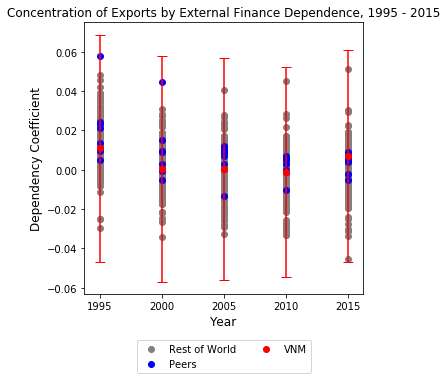

In [21]:
#external finance dependence
varlist = []
mycvar = 'ed_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('ed_' + i)
for i in allcountries:
    ed_reg['ed_' + i] = ed_reg['ed'] * ed_reg[i]
    varlist.append('ed_' + i)
ed_reg = ed_reg.drop('ed', axis=1)

ed_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    ed_n = ed_reg.loc[ed_reg['year'] == n]
    ed_n = ed_n.drop('year', axis=1)
    X = ed_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = ed_n['export_share']
    model = sm.OLS(Y, X).fit()
    ed_n = model.conf_int()
    ed_n.columns = ['lower', 'upper']
    ed_n = ed_n.join(pd.DataFrame(model.params))
    ed_n = ed_n.loc[ed_n.index.isin(varlist)]
    ed_n = ed_n.sort_values([0], ascending=False)
    ed_n['year'] = n
    ed_n = ed_n.reset_index()
    ed_n['error'] = ed_n['upper'] - ed_n[0]
    ed_n = ed_n.drop(['lower', 'upper'], axis=1)
    ed_n.columns = ['ID', 'mean', 'year', 'error']
    ed_out = ed_out.append(ed_n)
    del ed_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(ed_out.loc[~ed_out.ID.isin(mycvars)]['year'], ed_out.loc[~ed_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(ed_out.loc[ed_out.ID.isin(mycvars)]['year'], ed_out.loc[ed_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(ed_out.loc[ed_out.ID == mycvar]['year'], ed_out.loc[ed_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(ed_out.loc[ed_out.ID == mycvar]['year'], ed_out.loc[ed_out.ID == mycvar]['mean'], yerr=ed_out.loc[ed_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by External Finance Dependence, 1995 - 2015')
plt.show()

In [22]:
ed_out.to_csv('ed_out.csv')

In [24]:
del efd
del ed_reg
del isic_ex
del varlist
del mycvar

## factor intensity

In [25]:
RFII = pd.read_csv('Other Factors/RFII.csv')
RFII = RFII.drop('year', axis=1)
RFII.columns = ['commoditycode', 'hc', 'capital', 'land']
RFII['commoditycode'] = RFII['commoditycode'].astype(str)
RFII['commoditycode'] = RFII.commoditycode.apply(lambda s: '0' + s if len(s) == 5 else s) 
RFII['commoditycode'] = RFII['commoditycode'].str[0:4]
RFII['counter'] = 1
RFII['count'] = RFII.groupby('commoditycode')['counter'].transform(sum)
for i in ['hc', 'capital', 'land']:
    RFII['temp'] = RFII.groupby('commoditycode')[i].transform(sum)
    RFII[i] = RFII['temp'] / RFII['count']
RFII = RFII.drop(['counter', 'count', 'temp'], axis=1)
RFII = RFII.drop_duplicates()
RFII.head()

,commoditycode,hc,capital,land
0,0101,8.693829,102751.682776,0.541362
3,0102,8.598657,88836.004080,0.986606
5,0103,9.910921,146983.356467,1.249846
8,0104,5.114270,18137.420385,0.892085
10,0105,8.343131,70256.986602,0.273835


In [26]:
factor_reg = RFII.merge(df, on='commoditycode', how='outer')
factor_reg['commoditycode'] = factor_reg['commoditycode'].str[0:2]
factor_reg = factor_reg.loc[factor_reg.commoditycode != 'XX']
factor_reg['counter'] = 1
factor_reg['count'] = factor_reg.groupby('commoditycode')['counter'].transform(sum)
for i in ['hc', 'capital', 'land']:
    factor_reg['temp'] = factor_reg.groupby('commoditycode')[i].transform(sum)
    factor_reg[i] = factor_reg['temp'] / factor_reg['count']
    factor_reg[i] = factor_reg[i] / factor_reg[i].max()
factor_reg['export_value'] = factor_reg.groupby(['exporter', 'year', 'commoditycode'])['export_value'].transform(sum)
factor_reg = factor_reg.drop(['counter', 'count', 'temp'], axis=1)
factor_reg = factor_reg.drop_duplicates()
factor_reg = factor_reg.dropna()
factor_reg['export_agg'] = factor_reg.groupby(['exporter', 'year', 'commoditycode'])['export_value'].transform(sum)
factor_reg = factor_reg.drop(['export_value'], axis=1)
factor_reg = factor_reg.drop_duplicates(['exporter', 'year', 'commoditycode'])
factor_reg['export_tot'] = factor_reg.groupby(['exporter', 'year'])['export_agg'].transform(sum)
factor_reg['export_share'] = factor_reg['export_agg'] / factor_reg['export_tot']
factor_reg['log_export'] = np.log(factor_reg['export_agg']+1)
factor_reg = factor_reg.drop(['export_agg', 'export_tot'], axis=1)
factor_reg = factor_reg.sort_values(['year', 'exporter', 'commoditycode'])
factor_reg = factor_reg.join(pd.get_dummies(factor_reg['exporter'], drop_first=True))
factor_reg = factor_reg.join(pd.get_dummies(factor_reg['commoditycode'], drop_first=True))
factor_reg = factor_reg.drop(['commoditycode', 'exporter'], axis=1)
factor_reg['year'] = factor_reg['year'].astype(int)
factor_reg.head()

,hc,capital,land,year,export_share,log_export,AFG,AGO,AIA,ALB,...,89,90,91,92,93,94,95,96,97,99
0,0.757108,0.528186,0.614151,1995,0.000030,9.875602,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6804,0.860288,0.591780,0.700917,1995,0.000048,10.332962,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18144,0.787208,0.650604,0.404082,1995,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26082,0.883307,0.573032,0.468387,1995,0.001073,13.439095,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37422,0.792059,0.444759,0.508741,1995,0.000000,0.000000,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


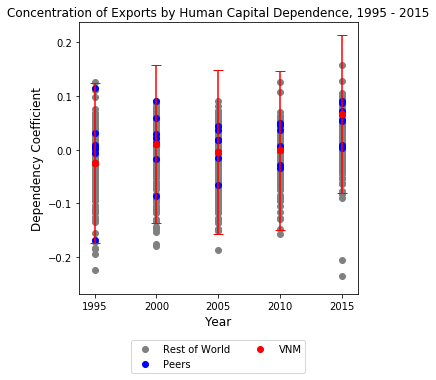

In [27]:
#hc
hc = factor_reg.drop(['capital', 'land'],axis = 1)
varlist = []
mycvar = 'hc_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('hc_' + i)
for i in allcountries:
    hc['hc_' + i] = hc['hc'] * hc[i]
    varlist.append('hc_' + i)
hc = hc.drop('hc', axis=1)

hc_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    hc_n = hc.loc[hc['year'] == n]
    hc_n = hc_n.drop('year', axis=1)
    X = hc_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = hc_n['export_share']
    model = sm.OLS(Y, X).fit()
    hc_n = model.conf_int()
    hc_n.columns = ['lower', 'upper']
    hc_n = hc_n.join(pd.DataFrame(model.params))
    hc_n = hc_n.loc[hc_n.index.isin(varlist)]
    hc_n = hc_n.sort_values([0], ascending=False)
    hc_n['year'] = n
    hc_n = hc_n.reset_index()
    hc_n['error'] = hc_n['upper'] - hc_n[0]
    hc_n = hc_n.drop(['lower', 'upper'], axis=1)
    hc_n.columns = ['ID', 'mean', 'year', 'error']
    hc_out = hc_out.append(hc_n)
    del hc_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(hc_out.loc[~hc_out.ID.isin(mycvars)]['year'], hc_out.loc[~hc_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(hc_out.loc[hc_out.ID.isin(mycvars)]['year'], hc_out.loc[hc_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(hc_out.loc[hc_out.ID == mycvar]['year'], hc_out.loc[hc_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(hc_out.loc[hc_out.ID == mycvar]['year'], hc_out.loc[hc_out.ID == mycvar]['mean'], yerr=hc_out.loc[hc_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Human Capital Dependence, 1995 - 2015')
plt.show()

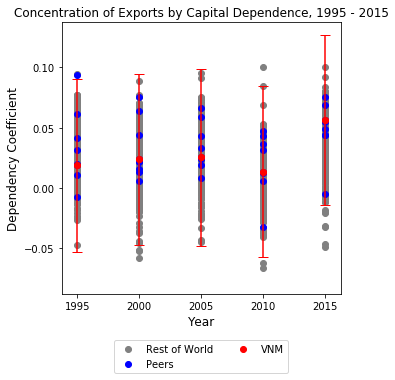

In [28]:
#capital
capital = factor_reg.drop(['hc', 'land'],axis = 1)
varlist = []
mycvar = 'capital_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('capital_' + i)
for i in allcountries:
    capital['capital_' + i] = capital['capital'] * capital[i]
    varlist.append('capital_' + i)
capital = capital.drop('capital', axis=1)

capital_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    capital_n = capital.loc[capital['year'] == n]
    capital_n = capital_n.drop('year', axis=1)
    X = capital_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = capital_n['export_share']
    model = sm.OLS(Y, X).fit()
    capital_n = model.conf_int()
    capital_n.columns = ['lower', 'upper']
    capital_n = capital_n.join(pd.DataFrame(model.params))
    capital_n = capital_n.loc[capital_n.index.isin(varlist)]
    capital_n = capital_n.sort_values([0], ascending=False)
    capital_n['year'] = n
    capital_n = capital_n.reset_index()
    capital_n['error'] = capital_n['upper'] - capital_n[0]
    capital_n = capital_n.drop(['lower', 'upper'], axis=1)
    capital_n.columns = ['ID', 'mean', 'year', 'error']
    capital_out = capital_out.append(capital_n)
    del capital_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(capital_out.loc[~capital_out.ID.isin(mycvars)]['year'], capital_out.loc[~capital_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(capital_out.loc[capital_out.ID.isin(mycvars)]['year'], capital_out.loc[capital_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(capital_out.loc[capital_out.ID == mycvar]['year'], capital_out.loc[capital_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(capital_out.loc[capital_out.ID == mycvar]['year'], capital_out.loc[capital_out.ID == mycvar]['mean'], yerr=capital_out.loc[capital_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Capital Dependence, 1995 - 2015')
plt.show()

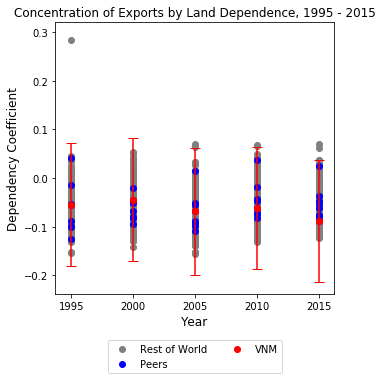

In [29]:
#land
land = factor_reg.drop(['capital', 'hc'],axis = 1)
varlist = []
mycvar = 'land_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('land_' + i)
for i in allcountries:
    land['land_' + i] = land['land'] * land[i]
    varlist.append('land_' + i)
land = land.drop('land', axis=1)

land_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    land_n = land.loc[land['year'] == n]
    land_n = land_n.drop('year', axis=1)
    X = land_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = land_n['export_share']
    model = sm.OLS(Y, X).fit()
    land_n = model.conf_int()
    land_n.columns = ['lower', 'upper']
    land_n = land_n.join(pd.DataFrame(model.params))
    land_n = land_n.loc[land_n.index.isin(varlist)]
    land_n = land_n.sort_values([0], ascending=False)
    land_n['year'] = n
    land_n = land_n.reset_index()
    land_n['error'] = land_n['upper'] - land_n[0]
    land_n = land_n.drop(['lower', 'upper'], axis=1)
    land_n.columns = ['ID', 'mean', 'year', 'error']
    land_out = land_out.append(land_n)
    del land_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(land_out.loc[~land_out.ID.isin(mycvars)]['year'], land_out.loc[~land_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(land_out.loc[land_out.ID.isin(mycvars)]['year'], land_out.loc[land_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(land_out.loc[land_out.ID == mycvar]['year'], land_out.loc[land_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(land_out.loc[land_out.ID == mycvar]['year'], land_out.loc[land_out.ID == mycvar]['mean'], yerr=land_out.loc[land_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Land Dependence, 1995 - 2015')
plt.show()

In [30]:
hc_out.to_csv('hc_out.csv')
capital_out.to_csv('capital_out.csv')
land_out.to_csv('land_out.csv')

In [31]:
del hc
del hc_out
del capital
del capital_out
del factor_reg
del RFII
del land
del land_out
del varlist
del mycvar

## contracts

In [32]:
contracts = pd.read_csv('Other Factors/contract dependency.csv')
contracts.head()

,industry_code,frac_lib_diff_int
0,1111A0,0.314193
1,1111B0,0.173474
2,111200,0.338533
3,111335,0.432367
4,1113A0,0.358308


In [33]:
oldnew = pd.read_csv('Other Factors/1997 2007 BEA Concordance.csv')
oldnew = oldnew.drop(['1997 name', '2007 name'], axis=1)
oldnew.columns = ['industry_code', 'BEA']
oldnew.head()

,industry_code,BEA
0,111335,111300
1,1113A0,111300
2,111910,111900
3,111920,111900
4,1119A0,111900


In [34]:
contract_merge = oldnew.merge(contracts, on='industry_code', how='outer')
contract_merge = contract_merge.dropna()
contract_merge['counter'] = 1
contract_merge['count'] = contract_merge.groupby('BEA')['counter'].transform(sum)
contract_merge['temp'] = contract_merge.groupby('BEA')['frac_lib_diff_int'].transform(sum)
contract_merge['contract'] = contract_merge['temp'] / contract_merge['count']
contract_merge = contract_merge.drop(['frac_lib_diff_int', 'counter', 'count', 'temp', 'industry_code'], axis=1)
contract_merge = contract_merge.drop_duplicates()
contract_merge.head()

,BEA,contract
0,111300,0.395338
2,111900,0.286099
6,1121A0,0.254960
7,113000,0.411757
9,114000,0.441843


In [35]:
contract = BEA_ex.merge(contract_merge, on='BEA', how='outer')
contract = contract.dropna()
contract = contract.sort_values(['exporter', 'year', 'BEA'])
contract = contract.join(pd.get_dummies(contract['exporter'], drop_first=True))
contract = contract.join(pd.get_dummies(contract['BEA'], drop_first=True))
contract = contract.drop(['BEA', 'exporter'], axis=1)
contract['year'] = contract['year'].astype(int)
contract.head()

,year,export_share,log_export,contract,AFG,AGO,AIA,ALB,AND,ANS,...,336612,336991,337127,339113,339115,339910,339920,339930,339940,339990
0,1995,0.003702,14.260593,0.314193,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,1995,0.016417,15.750102,0.173474,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2268,1995,0.000000,0.000000,0.338533,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3402,1995,0.000000,0.000000,0.395338,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4536,1995,0.000000,0.000000,0.428349,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


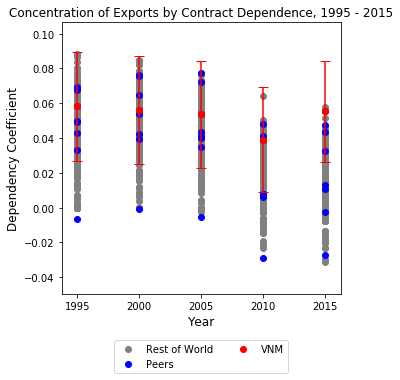

In [36]:
#contract
varlist = []
mycvar = 'contract_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('contract_' + i)
for i in allcountries:
    contract['contract_' + i] = contract['contract'] * contract[i]
    varlist.append('contract_' + i)
contract = contract.drop('contract', axis=1)

contract_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    contract_n = contract.loc[contract['year'] == n]
    contract_n = contract_n.drop('year', axis=1)
    X = contract_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = contract_n['export_share']
    model = sm.OLS(Y, X).fit()
    contract_n = model.conf_int()
    contract_n.columns = ['lower', 'upper']
    contract_n = contract_n.join(pd.DataFrame(model.params))
    contract_n = contract_n.loc[contract_n.index.isin(varlist)]
    contract_n = contract_n.sort_values([0], ascending=False)
    contract_n['year'] = n
    contract_n = contract_n.reset_index()
    contract_n['error'] = contract_n['upper'] - contract_n[0]
    contract_n = contract_n.drop(['lower', 'upper'], axis=1)
    contract_n.columns = ['ID', 'mean', 'year', 'error']
    contract_out = contract_out.append(contract_n)
    del contract_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(contract_out.loc[~contract_out.ID.isin(mycvars)]['year'], contract_out.loc[~contract_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(contract_out.loc[contract_out.ID.isin(mycvars)]['year'], contract_out.loc[contract_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(contract_out.loc[contract_out.ID == mycvar]['year'], contract_out.loc[contract_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(contract_out.loc[contract_out.ID == mycvar]['year'], contract_out.loc[contract_out.ID == mycvar]['mean'], yerr=contract_out.loc[contract_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Contract Dependence, 1995 - 2015')
plt.show()

In [37]:
contract_out.to_csv('contract_out.csv')

In [38]:
del contract
del contracts
del oldnew
del contract_merge
del contract_out
del varlist
del mycvar

## infrastructure

In [39]:
#get US 2007 input output data
usa = pd.read_csv('input_output.csv')
usa = usa.fillna(0)
usa = usa.loc[usa.Code.isin(['221100', '221300', '517110', '482000', '484000'])]
usa = usa.drop('Commodity Description', axis=1)
usa = usa.set_index('Code')
usa = usa.transpose()
usa = usa.reset_index()
usa.columns = ['BEA', 'electricity', 'water', 'rail', 'truck', 'internet']
usa['electricity'] = usa['electricity'] / usa['electricity'].max()
usa['water'] = usa['water'] / usa['water'].max()
usa['rail'] = usa['rail'] / usa['rail'].max()
usa['truck'] = usa['truck'] / usa['truck'].max()
usa['internet'] = usa['internet'] / usa['internet'].max()
usa.head()

,BEA,electricity,water,rail,truck,internet
0,1111A0,0.001503,0.025084,0.0,0.000588,0.000258
1,1111B0,0.003714,0.162354,0.0,0.010970,0.000746
2,111200,0.002009,0.028047,0.0,0.003134,0.000115
3,111300,0.001907,0.027257,0.0,0.003722,0.000115
4,111400,0.000506,0.003753,0.0,0.000000,0.000172


In [40]:
regress = BEA_ex.merge(usa, on='BEA', how='outer')
regress = regress.dropna()
regress = regress.sort_values(['exporter', 'year', 'BEA'])
regress = regress.join(pd.get_dummies(regress['exporter'], drop_first=True))
regress = regress.join(pd.get_dummies(regress['BEA'], drop_first=True))
regress = regress.drop(['BEA', 'exporter'], axis=1)
regress['year'] = regress['year'].astype(int)
regress.head()

,year,export_share,log_export,electricity,water,rail,truck,internet,AFG,AGO,...,339112,339113,339114,339115,339910,339920,339930,339940,339950,339990
0,1995,0.003702,14.260593,0.001503,0.025084,0.0,0.000588,0.000258,0,0,...,0,0,0,0,0,0,0,0,0,0
1134,1995,0.016417,15.750102,0.003714,0.162354,0.0,0.010970,0.000746,0,0,...,0,0,0,0,0,0,0,0,0,0
2268,1995,0.000000,0.000000,0.002009,0.028047,0.0,0.003134,0.000115,0,0,...,0,0,0,0,0,0,0,0,0,0
3402,1995,0.000000,0.000000,0.001907,0.027257,0.0,0.003722,0.000115,0,0,...,0,0,0,0,0,0,0,0,0,0
4536,1995,0.000000,0.000000,0.000506,0.003753,0.0,0.000000,0.000172,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
del BEA_ex
del usa
del concord
del IDlist
del naics_ex
del test2
del test
del NAICS
del HS
del df1
del df2
del df

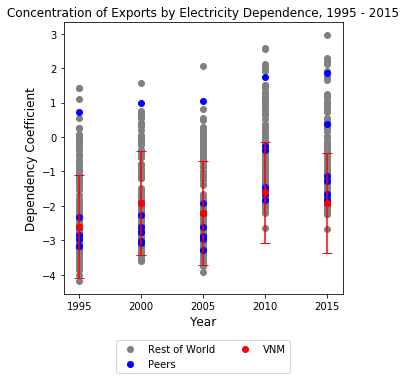

In [42]:
#electricity
elec = regress.drop(['rail', 'truck', 'internet', 'water'],axis = 1)
varlist = []
mycvar = 'elec_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('elec_' + i)
for i in allcountries:
    elec['elec_' + i] = elec['electricity'] * elec[i]
    varlist.append('elec_' + i)
elec = elec.drop('electricity', axis=1)

elec_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    elec_n = elec.loc[elec['year'] == n]
    elec_n = elec_n.drop('year', axis=1)
    X = elec_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = elec_n['export_share']
    model = sm.OLS(Y, X).fit()
    elec_n = model.conf_int()
    elec_n.columns = ['lower', 'upper']
    elec_n = elec_n.join(pd.DataFrame(model.params))
    elec_n = elec_n.loc[elec_n.index.isin(varlist)]
    elec_n = elec_n.sort_values([0], ascending=False)
    elec_n['year'] = n
    elec_n = elec_n.reset_index()
    elec_n['error'] = elec_n['upper'] - elec_n[0]
    elec_n = elec_n.drop(['lower', 'upper'], axis=1)
    elec_n.columns = ['ID', 'mean', 'year', 'error']
    elec_out = elec_out.append(elec_n)
    del elec_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(elec_out.loc[~elec_out.ID.isin(mycvars)]['year'], elec_out.loc[~elec_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(elec_out.loc[elec_out.ID.isin(mycvars)]['year'], elec_out.loc[elec_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(elec_out.loc[elec_out.ID == mycvar]['year'], elec_out.loc[elec_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(elec_out.loc[elec_out.ID == mycvar]['year'], elec_out.loc[elec_out.ID == mycvar]['mean'], yerr=elec_out.loc[elec_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Electricity Dependence, 1995 - 2015')
plt.show()

In [43]:
elec_out.to_csv('elec_out.csv')

In [44]:
del elec
del elec_out
del varlist
del mycvar

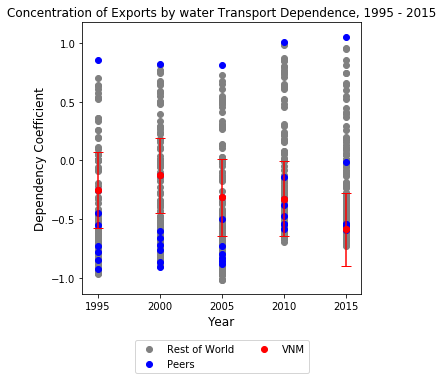

In [45]:
#water
water = regress.drop(['electricity', 'truck', 'internet', 'rail'],axis = 1)
varlist = []
mycvar = 'water_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('water_' + i)
for i in allcountries:
    water['water_' + i] = water['water'] * water[i]
    varlist.append('water_' + i)
water = water.drop('water', axis=1)

water_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    water_n = water.loc[water['year'] == n]
    water_n = water_n.drop('year', axis=1)
    X = water_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = water_n['export_share']
    model = sm.OLS(Y, X).fit()
    water_n = model.conf_int()
    water_n.columns = ['lower', 'upper']
    water_n = water_n.join(pd.DataFrame(model.params))
    water_n = water_n.loc[water_n.index.isin(varlist)]
    water_n = water_n.sort_values([0], ascending=False)
    water_n['year'] = n
    water_n = water_n.reset_index()
    water_n['error'] = water_n['upper'] - water_n[0]
    water_n = water_n.drop(['lower', 'upper'], axis=1)
    water_n.columns = ['ID', 'mean', 'year', 'error']
    water_n = water_n.loc[abs(water_n['mean'] - water_n['mean'].mean()) < 4*water_n['mean'].std()]
    water_n = water_n.loc[abs(water_n['mean'] - water_n['mean'].mean()) < 4*water_n['mean'].std()]
    water_out = water_out.append(water_n)
    del water_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(water_out.loc[~water_out.ID.isin(mycvars)]['year'], water_out.loc[~water_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(water_out.loc[water_out.ID.isin(mycvars)]['year'], water_out.loc[water_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(water_out.loc[water_out.ID == mycvar]['year'], water_out.loc[water_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(water_out.loc[water_out.ID == mycvar]['year'], water_out.loc[water_out.ID == mycvar]['mean'], yerr=water_out.loc[water_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by water Transport Dependence, 1995 - 2015')
plt.show()

In [46]:
water_out.to_csv('water_out.csv')

In [47]:
del water
del water_out
del varlist
del mycvar

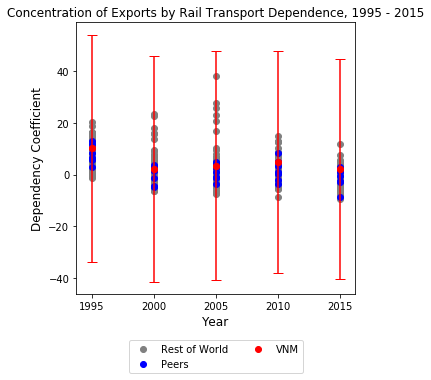

In [48]:
#rail
rail = regress.drop(['electricity', 'truck', 'internet', 'water'],axis = 1)
varlist = []
mycvar = 'rail_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('rail_' + i)
for i in allcountries:
    rail['rail_' + i] = rail['rail'] * rail[i]
    varlist.append('rail_' + i)
rail = rail.drop('rail', axis=1)

rail_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    rail_n = rail.loc[rail['year'] == n]
    rail_n = rail_n.drop('year', axis=1)
    X = rail_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = rail_n['export_share']
    model = sm.OLS(Y, X).fit()
    rail_n = model.conf_int()
    rail_n.columns = ['lower', 'upper']
    rail_n = rail_n.join(pd.DataFrame(model.params))
    rail_n = rail_n.loc[rail_n.index.isin(varlist)]
    rail_n = rail_n.sort_values([0], ascending=False)
    rail_n['year'] = n
    rail_n = rail_n.reset_index()
    rail_n['error'] = rail_n['upper'] - rail_n[0]
    rail_n = rail_n.drop(['lower', 'upper'], axis=1)
    rail_n.columns = ['ID', 'mean', 'year', 'error']
    rail_n = rail_n.loc[abs(rail_n['mean'] - rail_n['mean'].mean()) < 4*rail_n['mean'].std()]
    rail_n = rail_n.loc[abs(rail_n['mean'] - rail_n['mean'].mean()) < 4*rail_n['mean'].std()]
    rail_out = rail_out.append(rail_n)
    del rail_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(rail_out.loc[~rail_out.ID.isin(mycvars)]['year'], rail_out.loc[~rail_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(rail_out.loc[rail_out.ID.isin(mycvars)]['year'], rail_out.loc[rail_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(rail_out.loc[rail_out.ID == mycvar]['year'], rail_out.loc[rail_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(rail_out.loc[rail_out.ID == mycvar]['year'], rail_out.loc[rail_out.ID == mycvar]['mean'], yerr=rail_out.loc[rail_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Rail Transport Dependence, 1995 - 2015')
plt.show()

In [49]:
rail_out.to_csv('rail_out.csv')

In [50]:
del rail
del rail_out
del varlist
del mycvar

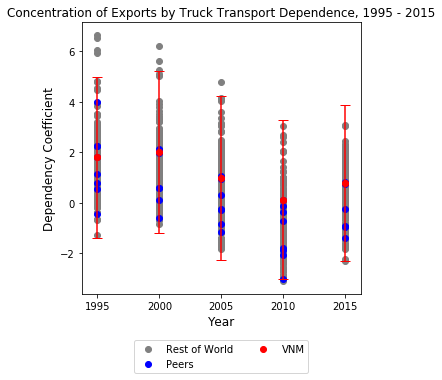

In [51]:
#truck
truck = regress.drop(['electricity', 'rail', 'internet', 'water'],axis = 1)
varlist = []
mycvar = 'truck_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('truck_' + i)
for i in allcountries:
    truck['truck_' + i] = truck['truck'] * truck[i]
    varlist.append('truck_' + i)
truck = truck.drop('truck', axis=1)

truck_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    truck_n = truck.loc[truck['year'] == n]
    truck_n = truck_n.drop('year', axis=1)
    X = truck_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = truck_n['export_share']
    model = sm.OLS(Y, X).fit()
    truck_n = model.conf_int()
    truck_n.columns = ['lower', 'upper']
    truck_n = truck_n.join(pd.DataFrame(model.params))
    truck_n = truck_n.loc[truck_n.index.isin(varlist)]
    truck_n = truck_n.sort_values([0], ascending=False)
    truck_n['year'] = n
    truck_n = truck_n.reset_index()
    truck_n['error'] = truck_n['upper'] - truck_n[0]
    truck_n = truck_n.drop(['lower', 'upper'], axis=1)
    truck_n.columns = ['ID', 'mean', 'year', 'error']
    truck_n = truck_n.loc[abs(truck_n['mean'] - truck_n['mean'].mean()) < 3*truck_n['mean'].std()]
    truck_out = truck_out.append(truck_n)
    del truck_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(truck_out.loc[~truck_out.ID.isin(mycvars)]['year'], truck_out.loc[~truck_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(truck_out.loc[truck_out.ID.isin(mycvars)]['year'], truck_out.loc[truck_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(truck_out.loc[truck_out.ID == mycvar]['year'], truck_out.loc[truck_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(truck_out.loc[truck_out.ID == mycvar]['year'], truck_out.loc[truck_out.ID == mycvar]['mean'], yerr=truck_out.loc[truck_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Truck Transport Dependence, 1995 - 2015')
plt.show()

In [52]:
truck_out.to_csv('truck_out.csv')

In [53]:
del truck
del truck_out
del varlist
del mycvar

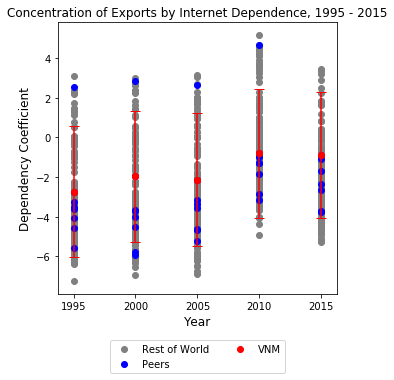

In [54]:
#internet
internet = regress.drop(['electricity', 'truck', 'rail', 'water'],axis = 1)
varlist = []
mycvar = 'internet_' + mycountry[0]
mycvars = []
for i in mycountries:
    mycvars.append('internet_' + i)
for i in allcountries:
    internet['internet_' + i] = internet['internet'] * internet[i]
    varlist.append('internet_' + i)
internet = internet.drop('internet', axis=1)

internet_out = pd.DataFrame(columns=['ID', 'mean', 'error'])

for n in [1995, 2000, 2005, 2010, 2015]:
    internet_n = internet.loc[internet['year'] == n]
    internet_n = internet_n.drop('year', axis=1)
    X = internet_n.drop('export_share', axis=1)
    X = sm.add_constant(X)
    Y = internet_n['export_share']
    model = sm.OLS(Y, X).fit()
    internet_n = model.conf_int()
    internet_n.columns = ['lower', 'upper']
    internet_n = internet_n.join(pd.DataFrame(model.params))
    internet_n = internet_n.loc[internet_n.index.isin(varlist)]
    internet_n = internet_n.sort_values([0], ascending=False)
    internet_n['year'] = n
    internet_n = internet_n.reset_index()
    internet_n['error'] = internet_n['upper'] - internet_n[0]
    internet_n = internet_n.drop(['lower', 'upper'], axis=1)
    internet_n.columns = ['ID', 'mean', 'year', 'error']
    internet_n = internet_n.loc[abs(internet_n['mean'] - internet_n['mean'].mean()) < 3*internet_n['mean'].std()]
    internet_out = internet_out.append(internet_n)
    del internet_n
    del X
    del Y
    del model

fig, ax = plt.subplots(figsize=(5,5))
ax.scatter(internet_out.loc[~internet_out.ID.isin(mycvars)]['year'], internet_out.loc[~internet_out.ID.isin(mycvars)]['mean'], c="gray")
ax.scatter(internet_out.loc[internet_out.ID.isin(mycvars)]['year'], internet_out.loc[internet_out.ID.isin(mycvars)]['mean'], c="blue")
ax.scatter(internet_out.loc[internet_out.ID == mycvar]['year'], internet_out.loc[internet_out.ID == mycvar]['mean'], c="red")
(_, caps, _) = ax.errorbar(internet_out.loc[internet_out.ID == mycvar]['year'], internet_out.loc[internet_out.ID == mycvar]['mean'], yerr=internet_out.loc[internet_out.ID == mycvar]['error'], fmt='o', capsize=5, c="red")
for cap in caps:
    cap.set_markeredgewidth(1)
ax.legend(['Rest of World', 'Peers', mycountry[0]], loc=9, bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Dependency Coefficient', fontsize=12)
plt.title('Concentration of Exports by Internet Dependence, 1995 - 2015')
plt.show()

In [55]:
internet_out.to_csv('internet_out.csv')

In [56]:
del internet
del internet_out
del varlist
del mycvar